### Importing Libraries

In [1]:
import torch
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

### Check if GPU Computing is Available

In [2]:
# Check if a GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch is using the GPU.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. PyTorch is using the CPU.")

CUDA is not available. PyTorch is using the CPU.


### Load Face Detection Model

In [3]:
# Load the YOLOv8 model and move it to the GPU if available
model = YOLO('yolov8n-face.pt').to(device)

### Face Detection for One Image


0: 640x480 3 faces, 1346.4ms
Speed: 87.1ms preprocess, 1346.4ms inference, 70.0ms postprocess per image at shape (1, 3, 640, 480)


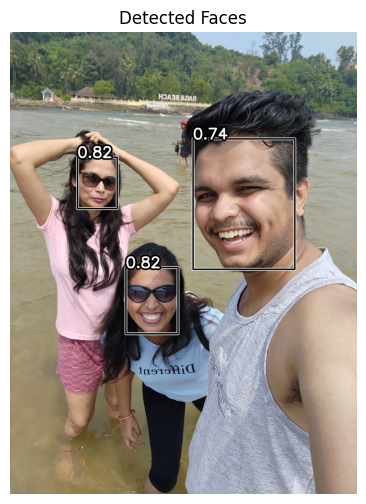

In [4]:
# Load and prepare the image
image = cv2.imread(r'G:\Computer_Vision\Data\Goa\P_20211015_112740.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
height, width = image_rgb.shape[:2]  # Get image dimensions

# Perform face detection
results = model(image)

# Process results and draw rectangles
for result in results:
    boxes = result.boxes

    for box in boxes:
        xyxy = box.xyxy[0].cpu().numpy()  # Get coordinates as a numpy array
        conf = box.conf[0].cpu().numpy() if box.conf is not None else 0  # Extract confidence

        if conf > 0.4:  # Confidence threshold
                face_detected = True
                x1, y1, x2, y2 = xyxy
                box_color = (0, 0, 0) 
                glow_color = (255, 255, 255)  
                text_color = (255, 255, 255) 
                box_thickness = int(0.003 * height) # Scale box thickness based on % of image height
                text_size = 3
                text_thickness = 10

                # Draw glow rectangle
                cv2.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), glow_color, box_thickness * 2)
                # Draw regular rectangle
                cv2.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), box_color, box_thickness)

                # Display confidence level text
                confidence_text = f"{conf:.2f}"  # Format confidence to 2 decimal places
                text_size_dims = cv2.getTextSize(confidence_text, cv2.FONT_HERSHEY_SIMPLEX, text_size, text_thickness)[0]

                # Draw glow text
                cv2.putText(image_rgb, confidence_text, (int(x1), int(y1)),
                            cv2.FONT_HERSHEY_SIMPLEX, text_size, box_color, text_thickness * 3)

                # Draw regular text
                cv2.putText(image_rgb, confidence_text, (int(x1), int(y1)),
                            cv2.FONT_HERSHEY_SIMPLEX, text_size, text_color, text_thickness)

# Display the image with detected faces using Matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.title('Detected Faces')
plt.axis('off')  # Hide axes
plt.show()

### Face Detection for Entire Folder with Image Segregation into Folders

In [5]:
# Path to the directory containing test images
image_dir = r'G:\Computer_Vision\Data\Goa'

# Get the parent directory of the image_dir
parent_dir = os.path.dirname(image_dir)

# Path to the v0.2_data directory
v0_2_data_dir = os.path.join(parent_dir, 'v0.2_data')

# Paths to the detected and not detected directories
detected_faces_dir = os.path.join(v0_2_data_dir, 'faces_detected')
no_face_dir = os.path.join(v0_2_data_dir, 'faces_not_detected')

# Create directories if they do not exist
os.makedirs(detected_faces_dir, exist_ok=True)
os.makedirs(no_face_dir, exist_ok=True)

# Get list of image paths
image_paths = [os.path.join(image_dir, image_name) for image_name in os.listdir(image_dir)
               if image_name.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Process all images with a progress bar
for image_path in tqdm(image_paths, desc="Processing Images", unit="image"):
    
    # Load and prepare the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for processing
    height, width = image.shape[:2]  # Get image dimensions

    # Perform face detection (suppress verbose output)
    results = model(image, verbose=False)

    # Flag to check if any face is detected
    face_detected = False

    # Process results and draw rectangles
    for result in results:
        boxes = result.boxes

        for box in boxes:
            xyxy = box.xyxy[0].cpu().numpy()  # Get coordinates as a numpy array
            conf = box.conf[0].cpu().numpy() if box.conf is not None else 0  # Extract confidence

            if conf > 0.4:  # Confidence threshold
                face_detected = True
                x1, y1, x2, y2 = xyxy
                box_color = (0, 0, 0) 
                glow_color = (255, 255, 255)  
                text_color = (255, 255, 255) 
                box_thickness = int(0.0015 * height) # Scale box thickness based on % of image height
                text_size = 2
                text_thickness = 4
                padding = 3

                # Draw glow rectangle
                cv2.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), glow_color, box_thickness * 2)
                # Draw regular rectangle
                cv2.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), box_color, box_thickness)

                # Display confidence level text
                confidence_text = f"{conf:.2f}"  # Format confidence to 2 decimal places
                text_size_dims = cv2.getTextSize(confidence_text, cv2.FONT_HERSHEY_SIMPLEX, text_size, text_thickness)[0]

                # Draw glow text
                cv2.putText(image_rgb, confidence_text, (int(x1), int(y1)),
                            cv2.FONT_HERSHEY_SIMPLEX, text_size, box_color, text_thickness * 3)

                # Draw regular text
                cv2.putText(image_rgb, confidence_text, (int(x1), int(y1)),
                            cv2.FONT_HERSHEY_SIMPLEX, text_size, text_color, text_thickness)

    # Convert back to BGR for saving
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    # Save image to 'detected_faces' folder if faces are detected
    if face_detected:
        cv2.imwrite(os.path.join(detected_faces_dir, os.path.basename(image_path)), image_bgr)
    else:
        # Save image to 'no_face' folder
        cv2.imwrite(os.path.join(no_face_dir, os.path.basename(image_path)), image)

Processing Images: 100%|██████████| 76/76 [00:29<00:00,  2.60image/s]
